# Nuclear Open Data

Pulling data from safecast.org and doing stuff with it

Imports go here

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gp
import shapely
import fiona
import json
import requests
import gmplot
import webbrowser
import numpy as np
import pandas as pd
import os
import csv

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

API Call function

In [2]:
def api_call(captured_after = "2017-05-01+00%3A00", captured_before = "2017-05-02+00%3A00"):
    base_url = "https://api.safecast.org/measurements.json"
    api_key = "hj5Nam6xXLATGcvUpP14"
    call_url = base_url + "?captured_after=" + captured_after + "&captured_before=" + captured_before
    # call_url = base_url + "?api_key=" + api_key
    print call_url
    r = requests.get(call_url)
    return r

In [3]:
r =  api_call()
the_json = json.loads(r.text)

https://api.safecast.org/measurements.json?captured_after=2017-05-01+00%3A00&captured_before=2017-05-02+00%3A00


test looking into the json output

In [4]:
lats = []
longs = []
set_size = len(the_json)
count = 0
sum = 0
for i in range(0, set_size):
    if the_json[i]["unit"] == "cpm":
        sum = the_json[i]["value"] + sum
        lats.append(the_json[i]["latitude"])
        longs.append(the_json[i]["longitude"])
        count += 1
average = round(sum / count,2)
print "Number of sites = " + str(count)
print "Average radiation level = " + str(average)

Number of sites = 19
Average radiation level = 36.63


plot the data points into google maps

In [17]:
map_lat = np.mean(working_dataset['Latitude'])
map_long = np.mean(working_dataset['Longitude'])
print map_lat
print map_long
gmap = gmplot.GoogleMapPlotter(map_lat, map_long, 4)

# gmap.scatter(lats, longs, 'cornflowerblue', size = 40, marker=True)
gmap.heatmap(working_dataset['Latitude'], working_dataset['Longitude'])

gmap.draw("mymap.html")

38.3966827917
70.300501559


<iframe src="file:///home/matthew/code1161base/open_data_project/mymap.html">
</iframe>

simple http server turn folder into localhost - python -m SimpleHTTPServer 8000

In [18]:
url = "mymap.html"
webbrowser.open(url)

True

https://raw.githubusercontent.com/datasets/geo-boundaries-world-110m/master/countries.geojson
http://biogeo.ucdavis.edu/data/gadm2.8/gadm28.shp.zip

In [2]:
def unzip_zipfile(zipped_file_path, put_it_here="."):
    import zipfile
    zip_of_suburbs = zipfile.ZipFile(zipped_file_path, 'r')
    print "Unzipping file"
    zip_of_suburbs.extractall(put_it_here)
    zip_of_suburbs.close()
    print "Cleaning up zip file"
    os.remove(zipped_file_path)
    print "Zip file removed"

In [3]:
def download_file(file_name, zip_file_name, web_file_path):
    # Get the data loaded. This is a bit complicated because it's online as a zip file.
    # If we don't have it right now, we need to get it and unzip it.
    
    if os.path.isfile(file_name):
        print "loading from file"
    else:
        if os.path.isfile(zip_file_name):
            print "unzipping"
            unzip_zipfile(zip_file_name)
        else:
            import requests
            print "loading from the internet"
            page = requests.get(web_file_path)
            with open(zip_file_name, 'wb') as z:
                z.write(page.content)
            unzip_zipfile(zip_file_name)

    print "done"

In [4]:
shp_file_name = "TM_WORLD_BORDERS-0.3.shp"
shp_zip_file_name = "TM_WORLD_BORDERS-0.3.zip"
shp_web_file_path = ("http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip")
download_file(shp_file_name, shp_zip_file_name, shp_web_file_path)

loading from file
done


In [5]:
nuke_file_name = "measurements.csv"
nuke_zip_file_name = "measurements.csv.zip"
nuke_web_file_path = ("https://api.safecast.org/system/measurements.csv")
download_file(nuke_file_name, nuke_zip_file_name, nuke_web_file_path)

loading from file
done


In [6]:
countries = gp.GeoDataFrame.from_file(shp_file_name)
countries.drop(["FIPS", "ISO2", "ISO3", "POP2005", "REGION", "SUBREGION", "UN"], axis=1, inplace=True)
countries.head(2)

,AREA,LAT,LON,NAME,geometry
0,44,17.078,-61.783,Antigua and Barbuda,"(POLYGON ((-61.686668 17.02444100000014, -61.7..."
1,238174,28.163,2.632,Algeria,"POLYGON ((2.96361 36.802216, 2.981389 36.80693..."


In [8]:
a = countries.iloc[0]
print a
for polygon in a.geometry:
    print polygon

AREA                                                       44
LAT                                                    17.078
LON                                                   -61.783
NAME                                      Antigua and Barbuda
geometry    (POLYGON ((-61.686668 17.02444100000014, -61.7...
Name: 0, dtype: object
POLYGON ((-61.686668 17.02444100000014, -61.73805999999996 16.98971899999998, -61.82916999999992 16.99694400000004, -61.87611399999997 17.01694100000009, -61.88056199999994 17.01972199999994, -61.88361399999997 17.02360900000008, -61.88583399999999 17.02805300000006, -61.88722200000001 17.03305400000011, -61.89111299999996 17.09416599999997, -61.88722200000001 17.10527399999995, -61.88417099999998 17.10972199999992, -61.83277900000002 17.16388699999999, -61.826393 17.16722099999998, -61.79444899999999 17.16333000000009, -61.78417200000001 17.15833299999997, -61.74417099999994 17.13721799999996, -61.674171 17.09360900000007, -61.67027999999993 17.0902750000000

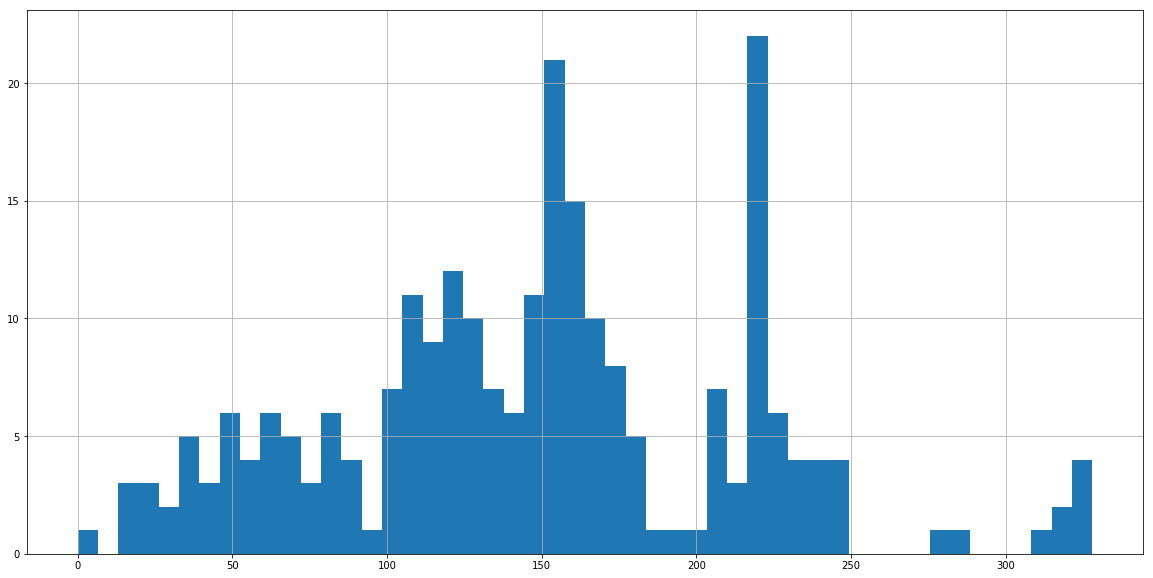

In [33]:
# countries.distance_from_SYD.hist(bins=50);

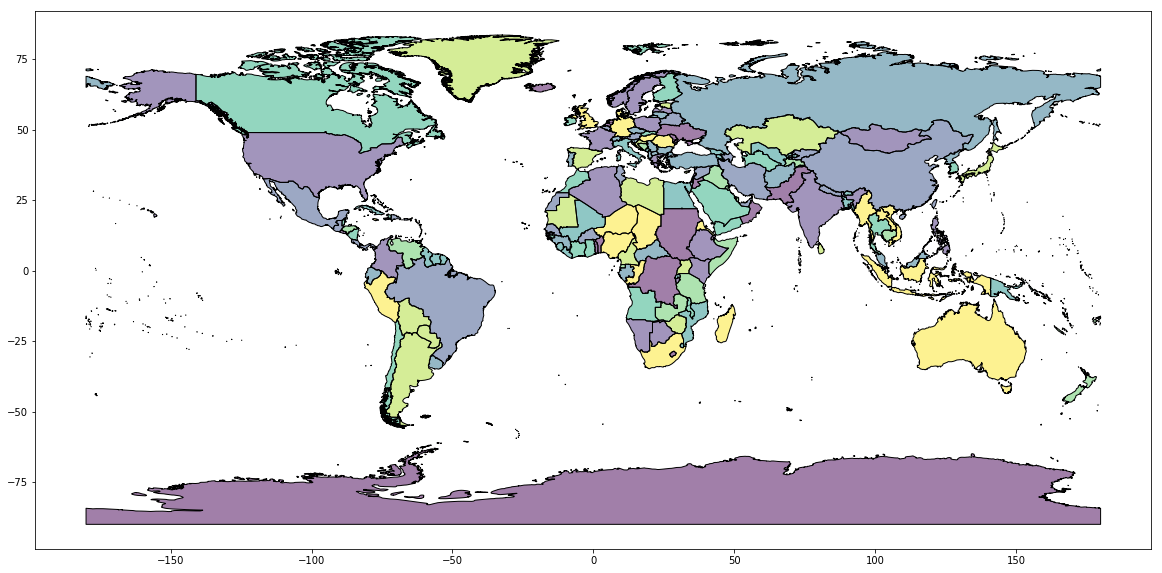

In [10]:
countries.plot();

In [11]:
with open(nuke_file_name) as nuke_file:
    head = [next(nuke_file) for x in xrange(3)]
print head

['Captured Time,Latitude,Longitude,Value,Unit,Location Name,Device ID,MD5Sum,Height,Surface,Radiation,Uploaded Time,Loader ID\n', '2020-02-03 17:00:00,37.507551666667,139.94117,72,cpm,,,6449bbf7ce3b30a8e05bc23a0bc40644,,,,2020-02-03 17:00:00,633\n', '2020-02-03 11:00:00,37.505445,0.016666666666667,68,cpm,,,a166df14f60b61095693684fc0f89c54,,,,2020-02-03 11:00:00,614\n']


In [9]:
start_date = "2017-01-01 00:00:00"
end_date = "2017-06-01 23:59:59"

if start_date < end_date:
    print True
else:
    print False

True


In [7]:
working_dataset = []
start_date = "2017-05-12 00:00:00"
end_date = "2017-05-12 23:59:59"
iter_csv = pd.read_csv(nuke_file_name, usecols=['Captured Time','Latitude', 'Longitude', 'Value', 'Unit'], iterator=True, chunksize=1000)
working_dataset = pd.concat([chunk[(chunk['Captured Time'] > start_date) & (chunk['Captured Time'] < end_date) & (chunk['Unit'] == "cpm")] for chunk in iter_csv])
working_dataset.head(6)
# df1 = df[(df.a != -1) & (df.b != -1)]
len(working_dataset)

23564

In [38]:
# working_dataset.drop(["Location Name", "Device ID", "MD5Sum", "Height", "Surface", "Radiation", "Uploaded Time", "Loader ID"], axis=1, inplace=True)
# working_dataset.head(6)

,Captured Time,Latitude,Longitude,Value,Unit
0,2020-02-03 17:00:00,37.507552,139.941170,72.0,cpm
1,2020-02-03 11:00:00,37.505445,0.016667,68.0,cpm
2,2020-02-03 11:00:00,37.507250,139.940000,55.0,cpm
3,2020-02-01 03:00:00,34.066487,-118.895217,50.0,cpm
4,2020-02-01 01:00:00,37.673233,140.066667,48.0,cpm
5,2020-02-01 01:00:00,37.674782,140.079895,52.0,cpm


In [8]:
# working_dataset["Country"] = working_dataset.apply(add_country, axis=1)
# working_dataset = working_dataset[working_dataset.Unit == "cpm"]
# len(working_dataset)
# working_dataset.head(100)

,Captured Time,Latitude,Longitude,Value,Unit
0,2020-02-03 17:00:00,37.507552,139.941170,72.0,cpm
1,2020-02-03 11:00:00,37.505445,0.016667,68.0,cpm
2,2020-02-03 11:00:00,37.507250,139.940000,55.0,cpm
3,2020-02-01 03:00:00,34.066487,-118.895217,50.0,cpm
4,2020-02-01 01:00:00,37.673233,140.066667,48.0,cpm
5,2020-02-01 01:00:00,37.674782,140.079895,52.0,cpm
6,2020-01-12 19:00:00,37.737123,140.726853,454.0,cpm
7,2020-01-12 19:00:00,37.517902,139.925478,59.0,cpm
8,2020-01-12 19:00:00,37.755880,140.703412,463.0,cpm
9,2020-01-12 19:00:00,37.539610,140.116577,47.0,cpm


In [39]:
def add_country(row):

    location = shapely.geometry.point.Point(row.Longitude, row.Latitude)
    for _, country_row in countries.iterrows():
        if type(country_row.geometry) == shapely.geometry.polygon.Polygon:
            if location.within(country_row.geometry):
                return country_row["NAME"]
        else:
            for polygon in country_row.geometry:
                if location.within(polygon):
                    return country_row["NAME"]


In [40]:
working_dataset["Country"] = working_dataset.apply(add_country, axis=1)
working_dataset.head(15)

,Captured Time,Latitude,Longitude,Value,Unit,Country
259759,2017-05-12 05:20:24,36.071850,129.341573,41.0,cpm,"Korea, Republic of"
259760,2017-05-12 05:20:19,36.071843,129.341550,43.0,cpm,"Korea, Republic of"
259761,2017-05-12 05:20:14,36.071840,129.341528,40.0,cpm,"Korea, Republic of"
259762,2017-05-12 05:20:09,36.071838,129.341518,40.0,cpm,"Korea, Republic of"
259763,2017-05-12 05:20:04,36.071838,129.341482,39.0,cpm,"Korea, Republic of"
259764,2017-05-12 05:19:59,36.071795,129.341400,41.0,cpm,"Korea, Republic of"
259765,2017-05-12 05:19:54,36.071790,129.341400,40.0,cpm,"Korea, Republic of"
259766,2017-05-12 05:19:49,36.071770,129.341362,41.0,cpm,"Korea, Republic of"
259767,2017-05-12 05:19:44,36.071787,129.341353,41.0,cpm,"Korea, Republic of"
259768,2017-05-12 05:19:39,36.071858,129.341385,38.0,cpm,"Korea, Republic of"


In [46]:
working_dataset.Country.value_counts()

Japan                 10100
United States          5740
Korea, Republic of     5122
Netherlands            1407
Czech Republic          334
Taiwan                  288
Switzerland             287
Hong Kong               286
Name: Country, dtype: int64

In [47]:
working_dataset.to_csv('last_working_set.csv', index=False)